<a href="https://colab.research.google.com/github/AeroEng16/FootballAnalysis/blob/main/lineDetectionAndHomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

try:
  from pytubefix import YouTube
  from pytubefix.cli import on_progress
except ModuleNotFoundError:
  !pip install pytubefix
  from pytubefix import YouTube
  from pytubefix.cli import on_progress

url = 'https://www.youtube.com/watch?v=PEvflD64RnE'

yt = YouTube(url, on_progress_callback=on_progress)
ys = yt.streams.get_highest_resolution()
ys.download(output_path="test")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:

import math
import plotly.express as px
import pandas as pd
from google.colab.patches import cv2_imshow
try:
  import supervision as sv
  from inference import get_model
except ImportError:
  #!pip install inference
  !pip install supervision
  !pip install inference-gpu
  import supervision as sv
  from inference import get_model
import cv2
import numpy as np
from PIL import Image
import os
import collections
from tqdm import tqdm
#LOOK AT CHANGING TO INFERENCE ON GPU


## Pitch Vertex Labels

Figure out how pitch config works and recreate alongside template image

In [ ]:


#!pip install -q git+https://github.com/roboflow/sports.git


from dataclasses import dataclass, field
from typing import List, Tuple


@dataclass
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

In [ ]:
CONFIG = SoccerPitchConfiguration()
CONFIG.vertices
CONFIG.width

7000

## Detect Players and Ball and Use detected keypoints to transform

In [ ]:


#Setup class to conduct the homography transformation

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                "Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)


### Initiliase the three models used

In [ ]:

model = get_model(
    model_id="football-field-detection-f07vi/14",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)

ballModel = get_model(
    model_id="football-ball-detection-rejhg/4",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)

playerModel = get_model(
    model_id="football-players-detection-3zvbc/12",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)



### Calculate the detections and kit color for each frame

In [ ]:
#CHANGE HOW THE LOCATION AND COLORS ARE SAVED SO THEY ARE SAVED AS A LIST

# Loop through frames, identifying objects and moving to flat pitch view view
#homography transform and saving in df
vid = cv2.VideoCapture("/content/drive/MyDrive/ML/FootballAnalysis/08fd33_4.mp4")
#ADD HOMOGRAPHY TRANSFORM AND DF STORING OF DATA

#NEED TO FIX SHIRT COLOR DETECTION

vidLength = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

## Initiliase dataframe to store detections

df = pd.DataFrame(data=None,columns=["Frame","Ball Location","PlayerDicts"])

kits_colors = []

for i in tqdm(range(vidLength)):
#while True:

  if i > 5000:
    break
  if i>0:
    if ret == False:
      break
  ret, frame = vid.read()

  if i ==0:
    ### First calculate the color of the grass

    # Convert image to HSV color space
    img = frame.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define a large range of green color in HSV
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([80, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Calculate the mean value of the pixels that are not masked
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    grass_color = cv2.mean(img, mask=mask)
    grass_color = grass_color[:3]
    #print("Grass BGR color: ", grass_color)


  #image = cv2.imread("test.png")
  image = frame
  # KeyPointDetections
  result = model.infer(image, confidence=0.3)[0]

  keypoints = sv.KeyPoints.from_inference(result)

  filter = keypoints.confidence[0] > 0.5

  keypoints.xy = keypoints.xy[0][filter][np.newaxis]
  keypoints.confidence = keypoints.confidence[0][filter][np.newaxis]

  vertex_annotator = sv.VertexAnnotator(radius=12)
  annotated_image = vertex_annotator.annotate(image.copy(), keypoints)

  transformer = ViewTransformer(
      target=np.array(CONFIG.vertices)[filter].astype(np.float32),
      source=np.array(keypoints.xy[0].astype(np.float32),)
  )

  #Ball Detection

  resultBall = ballModel.infer(image, confidence=0.5)[0]

  detectionsBall = sv.Detections.from_inference(resultBall)

  EllipseAnnotator_annotatorBall = sv.EllipseAnnotator(thickness=2)
  annotated_imageBall = EllipseAnnotator_annotatorBall.annotate(annotated_image.copy(), detectionsBall)

  xyBall = detectionsBall.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

  xyBall = transformer.transform_points(points=xyBall)


  #Player Detection

  resultPlayer = playerModel.infer(image, confidence=0.7)[0]

  detectionsPlayer = sv.Detections.from_inference(resultPlayer)

  xyPlayers = detectionsPlayer.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

  EllipseAnnotator_annotatorPlayer = sv.EllipseAnnotator(thickness=2)
  annotated_imagePlayer = EllipseAnnotator_annotatorPlayer.annotate(annotated_imageBall.copy(), detectionsPlayer)
  im = Image.fromarray(annotated_imagePlayer)
  #im.save("annotatedImage" + str(i) +".png")

  ### Work out kit color


#ADD A CHECK THAT IF ALL OF IMAGE IS MASKED THEN SET KIT COLOUR TO GREEN (or better way of dealing with this)

  filterPlayer = detectionsPlayer.data["class_name"]  == "player"
  filterGk = detectionsPlayer.data["class_name"]  == "goalkeeper"


  xyPlayers = xyPlayers[filterPlayer]
  xyPlayers = transformer.transform_points(points=xyPlayers)

  playerBoxes = detectionsPlayer.xyxy[filterPlayer]
  gkBoxes = detectionsPlayer.xyxy[filterGk]

  grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)
  playerDict = {}
  for counter,box in enumerate(playerBoxes):

      x1, y1, x2, y2 = map(int, box)
      player_img = frame[y1: y2, x1: x2]

      pixels = np.float32(player_img.reshape(-1, 3))

      n_colors = 2
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
      flags = cv2.KMEANS_RANDOM_CENTERS

      _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
      _, counts = np.unique(labels, return_counts=True)

      player_kit_color = list(palette[np.argmin(counts)])

      playerDict[counter] = {"kitColor": player_kit_color,"location": list(xyPlayers[counter])}
      kits_colors.append(player_kit_color)
      #CHECK THE LOCATION ABOVE IS THE BOTTOM MIDDLE COORDINATE

  ## Add data for current frame to df

  df.loc[i]= [i, xyBall, playerDict]

df.to_csv("transformedData.csv")



100%|██████████| 750/750 [06:27<00:00,  1.93it/s]


In [ ]:
df.head()

,Frame,Ball Location,PlayerDicts
0,0,"[[7270.787, 6748.5977]]","{0: {'kitColor': [152.65958, 233.52765, 173.50..."
1,1,"[[7270.562, 6749.3994]]","{0: {'kitColor': [152.65958, 233.52765, 173.50..."
2,2,[],"{0: {'kitColor': [229.0583, 231.01117, 224.936..."
3,3,"[[7285.4053, 6795.331]]","{0: {'kitColor': [147.89294, 227.35767, 168.81..."
4,4,"[[7288.5205, 6815.2437]]","{0: {'kitColor': [230.1704, 232.26118, 226.684..."


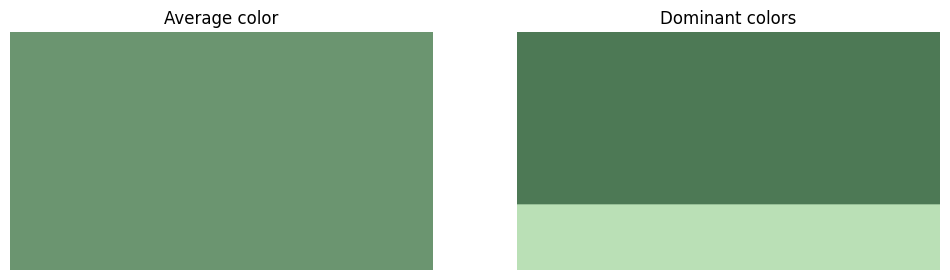

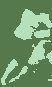

In [ ]:
      player_img = frame[y1: y2, x1: x2]

      average = player_img.mean(axis=0).mean(axis=0)

      pixels = np.float32(player_img.reshape(-1, 3))

      n_colors = 2
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
      flags = cv2.KMEANS_RANDOM_CENTERS

      _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
      _, counts = np.unique(labels, return_counts=True)

      player_kit_color = list(palette[np.argmin(counts)])

      import matplotlib.pyplot as plt

      avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

      indices = np.argsort(counts)[::-1]
      freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
      rows = np.int_(img.shape[0]*freqs)

      dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
      for i in range(len(rows) - 1):
          dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

      fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
      ax0.imshow(avg_patch)
      ax0.set_title('Average color')
      ax0.axis('off')
      ax1.imshow(dom_patch)
      ax1.set_title('Dominant colors')
      ax1.axis('off')
      plt.show(fig)

      palette = np.uint8(palette)
      res = palette[labels.flatten()]
      res2 = res.reshape((player_img.shape))
      cv2_imshow(res2)

## Use K-means clustering to determine what team each player detection belongs to

### Finally, based on the kit colors, calculate a k-means clustering to place the player detections in the relevant team

In [ ]:

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

kits_kmeans = KMeans(n_clusters=2)
kits_kmeans.fit(kits_colors);

kits_colors = np.array(kits_colors)

import plotly.express as px

fig = px.scatter_3d(
    x=kits_colors[:, 2],
    y=kits_colors[:, 1],
    z=kits_colors[:, 0],
    range_x=[0, 255],
    range_y=[0, 255],
    range_z=[0, 255],
    title="Kits Colors"
    )
fig.update_traces(marker_size = 4)
#fig.update_traces(marker_color = list(map(lambda e: (e[2], e[1], e[0]), kits_colors)))
fig.update_traces(marker_color = list(map(lambda e: 'rgba('+str(e[0])+','+str(e[1])+','+str(e[2])+',0.75)', kits_colors)))

fig.add_scatter3d(
    x=[kits_kmeans.cluster_centers_[0, 2]],
    y=[kits_kmeans.cluster_centers_[0, 1]],
    z=[kits_kmeans.cluster_centers_[0, 0]],
    marker_size = 20
)

fig.add_scatter3d(
    x=[kits_kmeans.cluster_centers_[1, 2]],
    y=[kits_kmeans.cluster_centers_[1, 1]],
    z=[kits_kmeans.cluster_centers_[1, 0]],
    marker_size = 20
)

for i, d in enumerate(fig.data[-2:]):
  d.marker.symbol='cross'
  d.marker.color=kits_kmeans.cluster_centers_[i, ::-1]

fig.show()



### Assign players from first frame to each frame and store in associated dataframe

In [ ]:
kits_kmeans.cluster_centers_ = kits_kmeans.cluster_centers_.astype(np.float32)
for key in df.iloc[0].PlayerDicts.keys():
  print(df.iloc[0].PlayerDicts[key]["kitColor"])
  print(kits_kmeans.predict(np.array(df.iloc[0].PlayerDicts[key]["kitColor"]).reshape(1,-1)))

  #kits_kmeans.predict(player_kit_color)


[152.65958, 233.52765, 173.50212]
[0]
[229.70627, 232.41776, 226.68538]
[1]
[148.50131, 225.77547, 169.87337]
[0]
[151.42253, 238.09038, 189.6162]
[0]
[155.36603, 239.82869, 177.34554]
[0]
[129.7507, 225.45024, 157.9365]
[0]
[227.82968, 228.09276, 212.05397]
[1]
[160.42322, 237.1125, 182.13571]
[0]
[225.05785, 231.37602, 220.07437]
[1]
[205.40439, 203.33069, 191.75499]
[1]
[224.96895, 229.49797, 214.85695]
[1]
[149.38661, 237.00084, 177.51883]
[0]
[215.8369, 221.71793, 204.62033]
[1]
[208.06667, 210.62465, 206.63562]
[1]
[146.00249, 228.58984, 171.4742]
[0]
[220.17786, 224.7143, 211.2624]
[1]
[162.16954, 236.14081, 182.11494]
[0]
[221.57558, 221.26454, 211.40407]
[1]
[186.78732, 224.22954, 182.85474]
[1]


## Loop through rest of frames and assign bounding boxes to each team

In [ ]:
import pandas as pd
import ast
url = "https://raw.githubusercontent.com/AeroEng16/FootballAnalysis/refs/heads/main/transformedData.csv"
df = pd.read_csv(url,usecols=[1,2,3])
df.PlayerDicts = df.PlayerDicts.apply(ast.literal_eval)

In [ ]:
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
pitchImage = Image.open("/content/drive/MyDrive/ML/FootballAnalysis/pitch_template.png")
pitchTemplate = np.float32(pitchImage)


pitchImageDimensions = (pitchTemplate.shape[0],pitchTemplate.shape[1])
pitchDimensions = (CONFIG.width,CONFIG.length)
#cv2_imshow(pitchImage)

for i in range(len(df.index)):

  pitchImage = pitchTemplate.copy()

  positions = [df.iloc[i].PlayerDicts[x]['location'] for x in df.iloc[i].PlayerDicts.keys()]

  mappedLocations = [[x[0]*pitchImageDimensions[0]/pitchDimensions[0],x[1]*pitchImageDimensions[1]/pitchDimensions[1]] for x in positions]

  for loc in mappedLocations:

    pitchImage=cv2.circle(pitchImage,tuple([int(loc[0]),int(loc[1])]),int(3),(255,0,0),-1)
  #cv2_imshow(pitchImage)
  pitchImage = pitchImage*255
  pitchImage = pitchImage.astype(np.uint8)
  pitchImagePNG = Image.fromarray(pitchImage)
  pitchImagePNG.save("annotatedPitchImage" + str(i) +".png")


#cv2_imshow(pitchImage)

KeyboardInterrupt: 

In [ ]:
import os
def save():
    os.system("ffmpeg -r 30 -i annotatedPitchImage%01d.png -vcodec mpeg4 -y movie.mp4")

save()

## Own trained model via transfer learning

In [ ]:
try:
  from ultralytics import YOLO
except ModuleNotFoundError:
  !pip install ultralytics
  from ultralytics import YOLO

# Load a pretrained YOLO11n model
modelPlayers = YOLO("/content/drive/MyDrive/ML/FootballAnalysis/Models/bestFootballYoloSoFar.pt")

# Run inference on 'bus.jpg' with arguments
modelPlayers.predict("test.png", save=True, conf=0.5)

modelBall = YOLO("/content/drive/MyDrive/ML/FootballAnalysis/Models/bestBallSoFar_0409.pt")

modelBall.predict("test.png", save=True, conf=0.1)


image 1/1 /content/test.png: 384x640 23 players, 1 referee, 315.0ms
Speed: 4.0ms preprocess, 315.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

image 1/1 /content/test.png: 384x640 2 balls, 5236.3ms
Speed: 8.5ms preprocess, 5236.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'ball'}
 obb: None
 orig_img: array([[[105, 146, 100],
         [ 98, 139,  93],
         [101, 150,  97],
         ...,
         [ 82,  92, 100],
         [ 85,  95, 103],
         [ 87,  97, 105]],
 
        [[104, 145,  99],
         [105, 146, 100],
         [114, 163, 110],
         ...,
         [ 87,  97, 105],
         [ 89,  99, 107],
         [ 90, 100, 108]],
 
        [[101, 150,  97],
         [110, 159, 106],
         [115, 172, 114],
         ...,
         [ 88,  98, 106],
         [ 90, 100, 108],
         [ 92, 102, 110]],
 
        ...,
 
        [[ 78, 103,  74],
         [ 78, 103,  74],
         [ 78, 103,  74],
         ...,
         [ 43,  47,  30],
         [ 44,  48,  31],
         [ 44,  48,  31]],
 
        [[ 78, 103,  74],
         [ 78, 103,  74],
         [ 78, 103,  74],
         ...,
         [ 55,  56, 